In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import joblib

In [39]:
import random

random.seed(10)

# Carga de datos

In [40]:
train_data = pd.read_csv("data/train_letters.csv")
test_data = pd.read_csv("data/validation_letters.csv")

In [41]:
train_data.head()

,sequence_id,target,file
0,148,q,q (7).png
1,182,i,i (4).png
2,29,a,a (7).png
3,145,u,u (5).png
4,5,z,z (2).png


# Analisis Exploratorio

In [42]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
train_letters = list(train_data.target.unique())
train_letters.sort()
print(f"Frases unicas : {train_letters}")

--------------------Train data--------------------
Cantidad de filas : 160
Frases unicas : ['a', 'b', 'c', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ñ']


In [43]:
print("--------------------Validation data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
val_letters = list(test_data.target.unique())
val_letters.sort()
print(f"Frases unicas : {val_letters}")

--------------------Validation data--------------------
Cantidad de filas : 23
Frases unicas : ['a', 'b', 'c', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ñ']


In [44]:
if (train_letters != val_letters):
    raise ValueError("Error between target and train")

In [45]:
train_data.describe()

,sequence_id
count,160.000000
mean,91.212500
std,52.603703
min,1.000000
25%,47.500000
50%,92.500000
75%,137.250000
max,183.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [46]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_Right_hand_{i}')
        cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [47]:
df = pd.read_csv("data/data_letters.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [48]:
df.head()

,sequence_id,target,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,148,q,1.000000,1.000000,0.868182,0.914128,0.820478,0.846905,0.774492,0.802124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,182,i,0.801343,1.000000,0.795936,0.950029,0.802861,0.893534,0.821283,0.854649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29,a,0.774669,0.981013,0.805534,0.934525,0.873408,0.883454,0.908579,0.843669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145,u,0.716703,1.000000,0.843178,0.945552,0.911234,0.847170,0.910536,0.746909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,z,0.844270,1.000000,0.965270,0.952916,1.000000,0.883615,0.934592,0.818524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

183
True
True


# Modelo

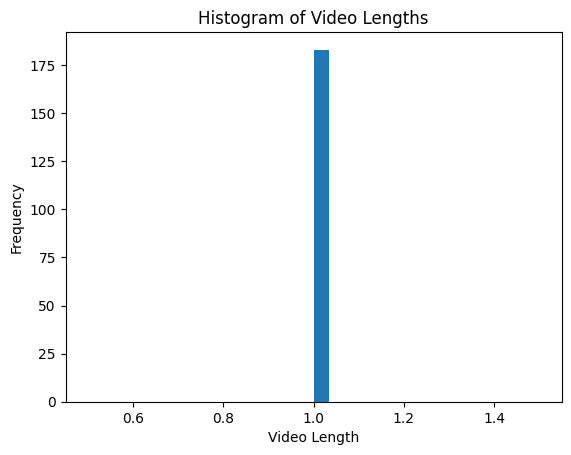

In [50]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [51]:
video_lengths.max()

1

In [52]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [53]:
def padding_videos(df):
    # Create a new DataFrame to store the filled rows
    target = []
    # Iterate over each group and fill remaining rows with zero
    for _, group in df.groupby('sequence_id'):
        target.append(group)
    
    filled_df = pd.concat(target)
    filled_df.reset_index(drop=True, inplace=True)
    filled_df = filled_df.fillna(0)
    return filled_df, target

def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [54]:
X_train, target = padding_videos(df_train)

In [55]:
y_train = padding_labels(X_train["target"])

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [56]:

del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

160 160


In [57]:
X_test, target = padding_videos(df_test)
y_test = padding_labels(X_test["target"] )
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

23 23


/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [58]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

True

In [59]:
len(X_train)

160

In [60]:
# num_samples_train = int(len(X_train)/max_seq_length)
# num_features_train = len(get_needed_cols())
num_classes_train = len(y_train[1])

# X_train = X_train.values.reshape(num_samples_train, max_seq_length, num_features_train)

In [61]:
# X_train = flat_X(X_train)
# X_test = flat_X(X_test)

In [62]:
# print('Train:', X_train.shape, y_train.shape)
# print('Test:', X_test.shape, y_test.shape)

# Modelo
La entrada son las coordenadas de la mano que están relacionados en totalidad con la letra (target).
Es un tipo de GLM donde se asume que la distribusión es Gauseana normal. 
No necesita de epocas porque aprende cual es la mejor ecuacion para minimizar el error de predicción.

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
# Initialize Linear Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42, max_features=10, min_samples_split=3)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [65]:
most_likely_predictions = np.argmax(y_pred, axis=1)
expected_labels = np.argmax(y_test, axis=1)

In [66]:
most_likely_predictions

array([12,  4, 16, 15, 19,  9,  3,  8, 13,  0, 18,  1, 10,  7, 17, 14,  6,
        5, 22,  2, 11, 20, 21])

In [67]:
expected_labels

array([12,  4, 16, 15, 19,  9,  3,  8, 13,  0, 18,  1, 10,  7, 17, 14,  6,
        5, 22,  2, 11, 20, 21])

In [68]:
predicted_labels = label_encoder.inverse_transform(most_likely_predictions)

In [69]:
expected_labels = label_encoder.inverse_transform(expected_labels)

In [70]:
correct = 0
for i in range(len(predicted_labels)):
    if (predicted_labels[i] == expected_labels[i]):
        correct += 1
        print("Correctamente predicha: ", predicted_labels[i])
    else:
        print(">> Incorrecta: ", predicted_labels[i], "contra", expected_labels[i])

Correctamente predicha:  p
Correctamente predicha:  g
Correctamente predicha:  u
Correctamente predicha:  t
Correctamente predicha:  x
Correctamente predicha:  m
Correctamente predicha:  e
Correctamente predicha:  l
Correctamente predicha:  q
Correctamente predicha:  a
Correctamente predicha:  w
Correctamente predicha:  b
Correctamente predicha:  n
Correctamente predicha:  k
Correctamente predicha:  v
Correctamente predicha:  r
Correctamente predicha:  i
Correctamente predicha:  h
Correctamente predicha:  ñ
Correctamente predicha:  c
Correctamente predicha:  o
Correctamente predicha:  y
Correctamente predicha:  z


In [71]:
print("Correct >> ", correct)
print("Expected >> ", len(test_data.target.unique()))
print("Ratio >> ", str(correct/len(test_data.target.unique())))

Correct >>  23
Expected >>  23
Ratio >>  1.0


# Reutilizando el modelo

In [72]:
# Save the model to a file
model_filename = 'letters_model.joblib'
joblib.dump(model, model_filename)

['letters_model.joblib']

In [73]:

# Load the model back from the file
loaded_model = joblib.load(model_filename)

In [74]:
predicted_class = loaded_model.predict([X_test.iloc[0]])
predicted_class = np.argmax(predicted_class, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)
"".join(predicted_label)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


'p'